In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time
import pystencils
import sympy
from lbmpy.session import *

In [2]:
# SOR iterative method with objects

# function to find final diffusion gradient with objects
def SOR_with_objects(N, omega,object_array,conc_mat):
    def SOR(conc_mat,omega):
        conc_mat[N-1] = 1
        
        # left boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][0] == 1:
                    conc_mat[k][0] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][0] = omega/4*(conc_mat[k+1][0] + conc_mat[k-1][0] + conc_mat[k][1] + conc_mat[k][N-1]) + (1-omega)*conc_mat[k][0]
        
        # middle of matrix
        for j in range(N-1):
            for i in range(1,N-1):
                # if part of object, concentration is zero
                if object_array[i][j] == 1:
                    conc_mat[i][j] = 0
                
                # otherwise: SOR equation
                else:
                    conc_mat[i][j] = (omega/4)*(conc_mat[i+1][j] + conc_mat[i-1][j] + conc_mat[i][j+1] + conc_mat[i][j-1]) + (1-omega)*conc_mat[i][j]
                    if conc_mat[i][j] < 0:
                        conc_mat[i][j] = 0
        # right boundary
        for k in range(1,N-1):
            # if part of object, concentration is zero
            if object_array[k][N-1] == 1:
                conc_mat[k][N-1] = 0
            
            # otherwise: SOR equation
            else:
                conc_mat[k][N-1] = omega/4*(conc_mat[k+1][N-1] + conc_mat[k-1][N-1] + conc_mat[k][0] + conc_mat[k][N-2]) + (1-omega)*conc_mat[k][N-1]

        return conc_mat

    # initialise parameters
    i = 0 # iterations
    epsilon = 10**-5
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR(conc_mat,omega)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
        i += 1
    return diff, i,conc_mat,conc_mat_old

In [3]:
# function to find the neighbours of a new object cell, add to set (so all candidates are unique) 
def get_candidates_SOR(object_loc,object_array,candidates):
    # check if north, south,east, west neighbours are NOT part of object, and add them to candidates
    if object_loc[1]!=N-1 and object_array[object_loc[0]][object_loc[1]+1] == 0:
        candidates.add((object_loc[0],object_loc[1]+1))
    if object_loc[1]!=0 and object_array[object_loc[0]][object_loc[1]-1] == 0:
        candidates.add((object_loc[0],object_loc[1]-1))
    if object_loc[0]!=N-1 and object_array[object_loc[0]+1][object_loc[1]] == 0:
        candidates.add((object_loc[0]+1,object_loc[1]))
    if object_loc[0]!=0 and object_array[object_loc[0]-1][object_loc[1]] == 0:
        candidates.add((object_loc[0]-1,object_loc[1]))

    return candidates

# function to calculate the SOR of a grid with object, until convergence, with growing object
def SOR_DLA_to_solution(N,eta,omega,iterations):
    # calculate the analytic solution at t=1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1-x+2*i)/(2*np.sqrt(D*t))) - scipy.special.erfc((1+x+2*i)/(2*np.sqrt(D*t))) for i in range(10000)])
    x = np.arange(0,1,1/N)
    analytic_matrix = analytic_sol(x, 1, t)

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N,N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # source top boundary
    conc_mat[N-1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N,N))
    object_array[0][50] = 1
    candidates = set()
    candidates = get_candidates_SOR((0,50), object_array, candidates)
    
    # first SOR 
    difference, i, conc_mat,concold = SOR_with_objects(N,omega,object_array,conc_mat)
    
    def choose_growth(N,eta,conc_mat, candidates):

        # calculate the probabilities of growth for each candidate
        probs = []
        for i in candidates:
            prob = (conc_mat[i]**eta)/np.sum([conc_mat[cand]**eta for cand in candidates])
            probs.append(prob)

        # choose one and grow
        list_candidates = list(candidates)
        chosengrowth = list_candidates[np.random.choice(len(candidates),p=probs)]
        object_array[chosengrowth] = 1
        candidates = get_candidates_SOR(chosengrowth, object_array, candidates)
        conc_mat[chosengrowth] = 0
        
        return object_array,conc_mat, candidates
    
    # keep track of iterations needed
    totaliterations = 0
    
    # loop until object is grown 'iterations' times, finding SOR with each growth
    for k in range(iterations):
        object_array,conc_mat, candidates = choose_growth(N,eta,conc_mat, candidates)
        difference, i, conc_mat,concold = SOR_with_objects(N,omega,object_array,conc_mat)
        totaliterations += i

    plt.imshow(conc_mat,origin='lower',extent=[0,1,0,1],cmap='Spectral')
    return conc_mat,object_array, totaliterations
    

In [26]:
# function to make a combined imshow plot, where the object is visible along with the gradient

## code (with small adjustments) based on answer at: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
def plot_object_gradient(conc_mat, object_array,eta):
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N+3)
    cmap2._lut[:,-1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    img3 = plt.imshow(object_array, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0,1,0,1])

    plt.title(f"Object with gradient, eta = {eta}")

    
    plt.show()

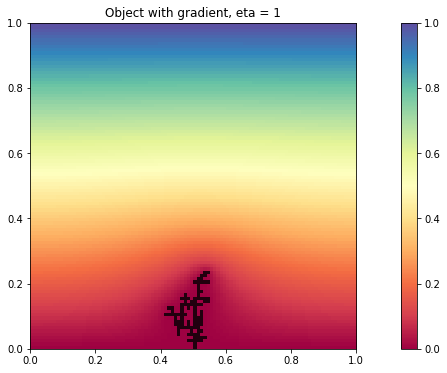

In [27]:
# test run

# initialise parameters
N = 100
eta = 1 
omega = 1.5
iterations = 100

conc_mat,object_array, totaliterations = SOR_DLA_to_solution(N,eta,omega,iterations)
plot_object_gradient(conc_mat, object_array, 1)

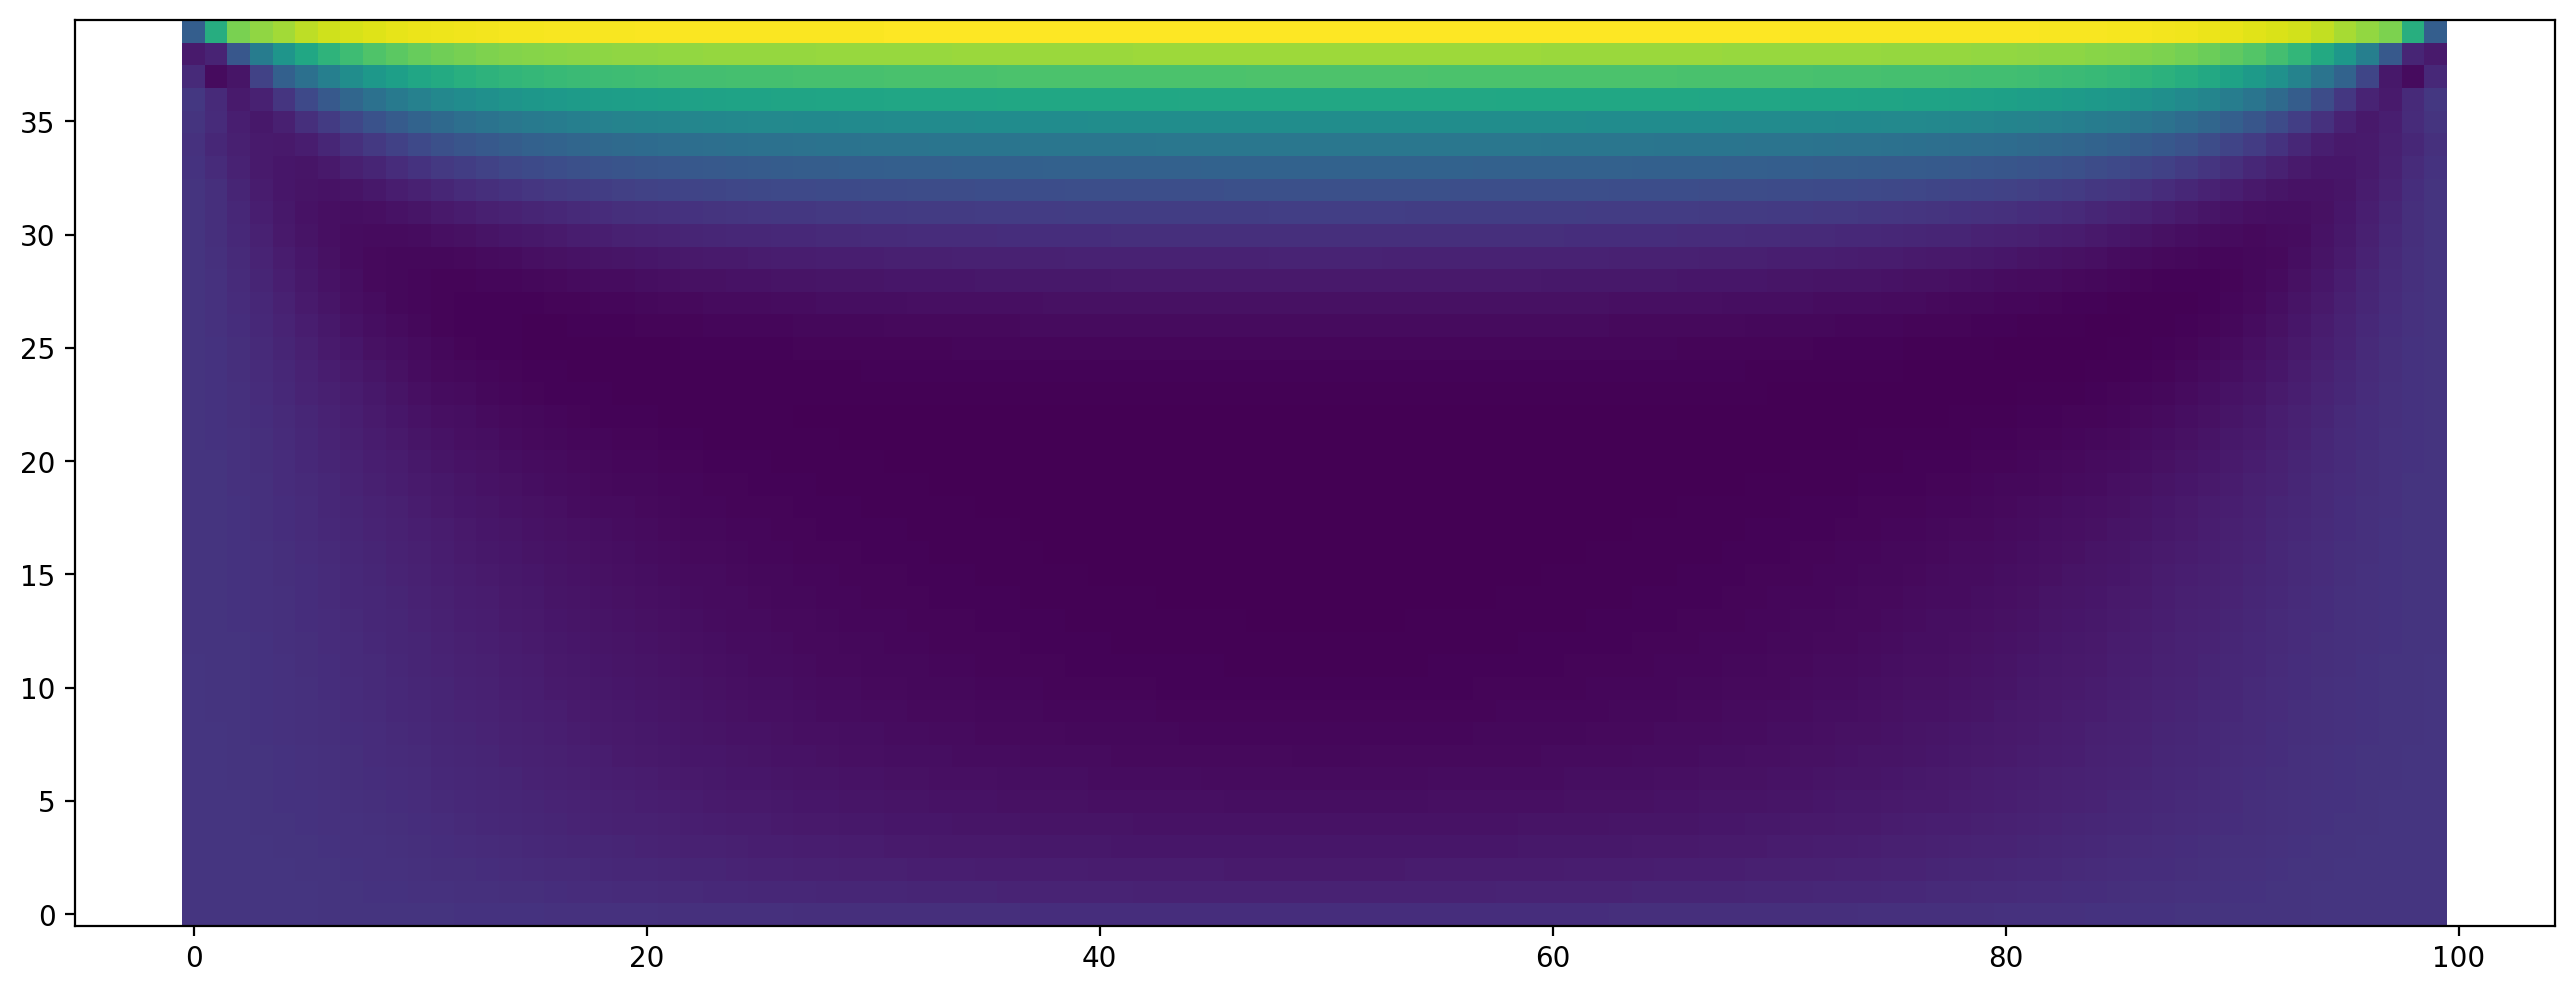

In [17]:
import pystencils
import sympy
from lbmpy.session import *
# example lid driven cavity
ldc = create_lid_driven_cavity(domain_size=(100, 40), method='srt', relaxation_rate=1.6)

ldc.run(500)
plt.figure(dpi=200)
#plt.vector_field(ldc.velocity_slice());

plt.scalar_field(ldc.velocity[:, :, 0])

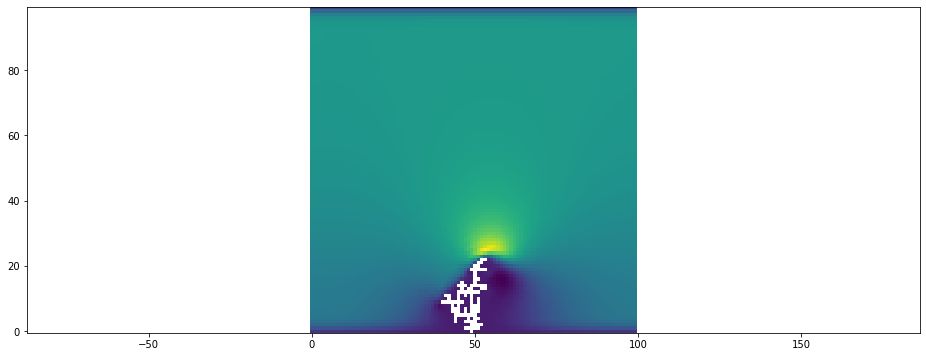

In [54]:
scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
#plt.vector_field(scenario.velocity_slice());